<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/StoreToCustomerDeliveryTimeEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [172]:
df = pd.read_csv('/content/historical_data.csv', on_bad_lines='skip')

# Basic Analysis

In [173]:
df.shape

(277639, 14)

In [174]:
df.sample(5)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
231073,1.0,5260,fast,4.0,7,1805,4,145,350,9.0,8.0,14.0,251.0,222.0
81285,2.0,1925,indian,2.0,4,2990,4,395,950,47.0,38.0,50.0,251.0,795.0
98025,1.0,1878,asian,3.0,3,4000,3,600,1900,48.0,48.0,59.0,251.0,533.0
159243,2.0,3813,greek,5.0,3,3695,3,699,1599,53.0,38.0,38.0,251.0,729.0
200884,1.0,3827,indian,2.0,3,2650,2,500,1650,9.0,6.0,6.0,251.0,41.0


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277639 entries, 0 to 277638
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     276246 non-null  float64
 1   store_id                                      277639 non-null  int64  
 2   store_primary_category                        271145 non-null  object 
 3   order_protocol                                276232 non-null  float64
 4   total_items                                   277639 non-null  int64  
 5   subtotal                                      277639 non-null  int64  
 6   num_distinct_items                            277639 non-null  int64  
 7   min_item_price                                277639 non-null  int64  
 8   max_item_price                                277639 non-null  int64  
 9   total_onshift_dashers                         25

In [176]:
df.isnull().sum()/df.shape[0]*100

market_id                                       0.501731
store_id                                        0.000000
store_primary_category                          2.339009
order_protocol                                  0.506773
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           8.368061
total_busy_dashers                              8.368061
total_outstanding_orders                        8.368421
estimated_order_place_duration                  0.001081
estimated_store_to_consumer_driving_duration    0.266533
dtype: float64

In [177]:
df.duplicated().sum()

80484

In [178]:
df = df.drop_duplicates(keep='first')

In [179]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196168.000000,197155.000000,196160.000000,197155.000000,197155.000000,197155.000000,197155.000000,197155.000000,181112.000000,181112.000000,181111.000000,197152.000000,196626.000000
mean,2.975919,3530.488078,2.882234,3.198088,2684.047785,2.672238,686.084938,1159.822683,44.820592,41.754964,58.068577,308.571523,545.479896
std,1.522624,2053.770873,1.503857,2.667195,1823.601670,1.630581,522.081092,558.549798,34.532031,32.179881,52.705592,90.146342,219.349239
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3396.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,372.000000,563.000000,1008.000000,2715.000000,2088.000000


In [180]:
df.corr()['estimated_store_to_consumer_driving_duration']

market_id                                       0.007275
store_id                                        0.001701
order_protocol                                 -0.008345
total_items                                     0.004392
subtotal                                        0.034284
num_distinct_items                              0.022298
min_item_price                                  0.003500
max_item_price                                  0.026382
total_onshift_dashers                           0.045772
total_busy_dashers                              0.044358
total_outstanding_orders                        0.039665
estimated_order_place_duration                 -0.024506
estimated_store_to_consumer_driving_duration    1.000000
Name: estimated_store_to_consumer_driving_duration, dtype: float64

In [181]:
df.cov()['estimated_store_to_consumer_driving_duration']

market_id                                           2.429731
store_id                                          766.182245
order_protocol                                     -2.753023
total_items                                         2.570069
subtotal                                        13711.121922
num_distinct_items                                  7.975678
min_item_price                                    400.764941
max_item_price                                   3232.572027
total_onshift_dashers                             345.534332
total_busy_dashers                                311.759677
total_outstanding_orders                          456.716716
estimated_order_place_duration                   -484.642315
estimated_store_to_consumer_driving_duration    48114.088794
Name: estimated_store_to_consumer_driving_duration, dtype: float64

# EDA

## Univariant Aanalysis

In [182]:
numericFeature = []
categoricalFeature = []
for feature in df.columns:
  if df[feature].dtype == 'float64' or df[feature].dtype == 'int64':
    numericFeature.append(feature)
  else:
    categoricalFeature.append(feature)

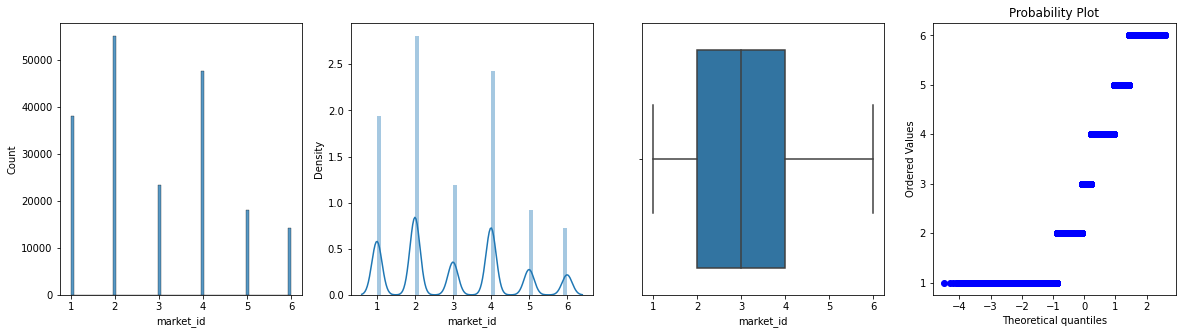

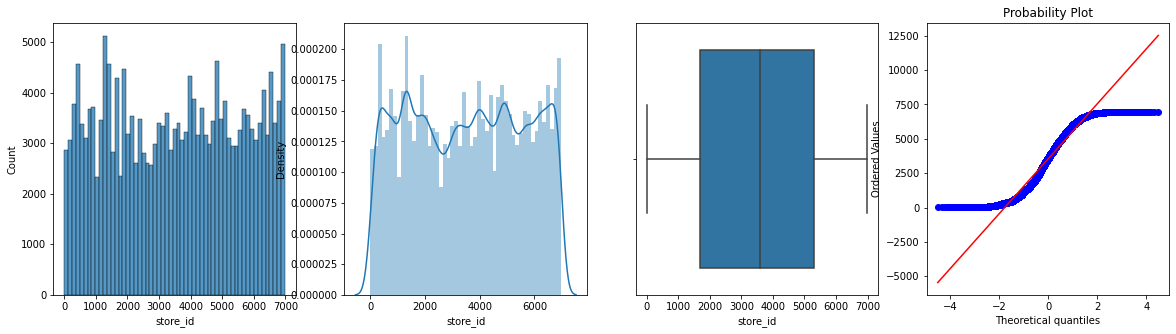

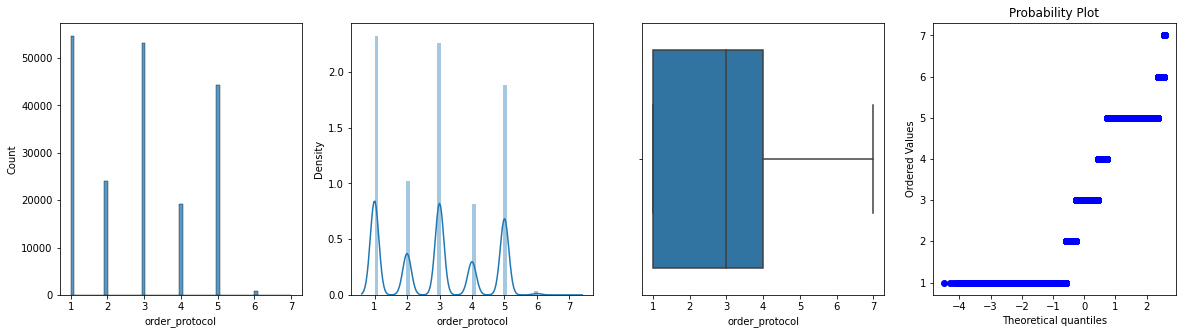

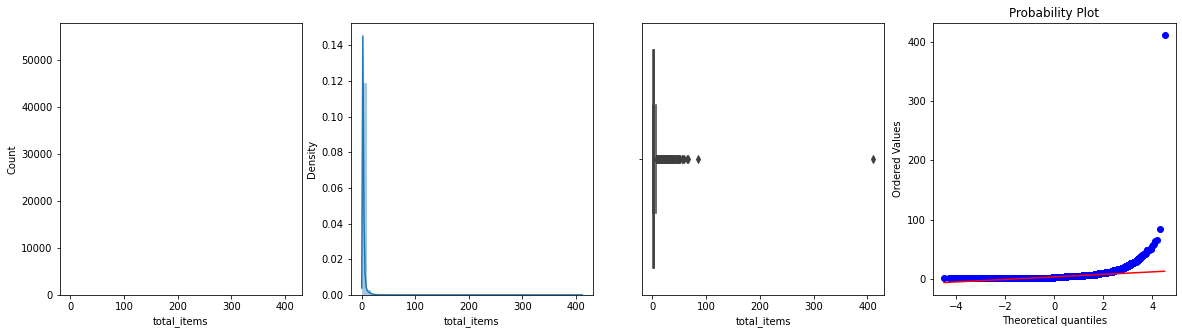

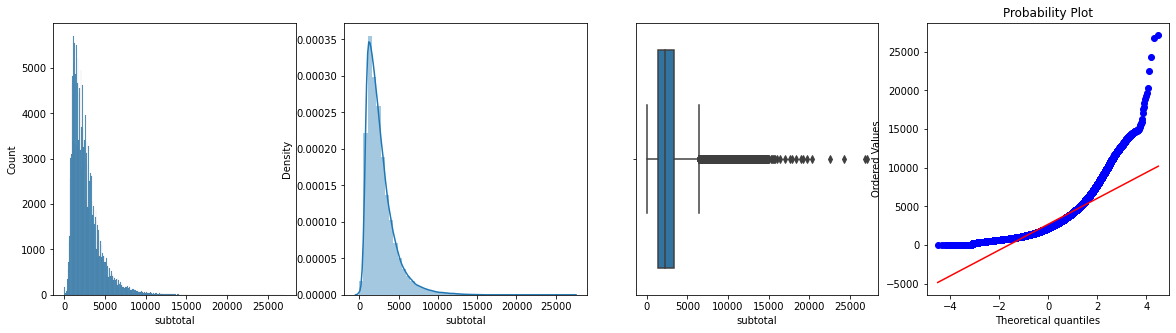

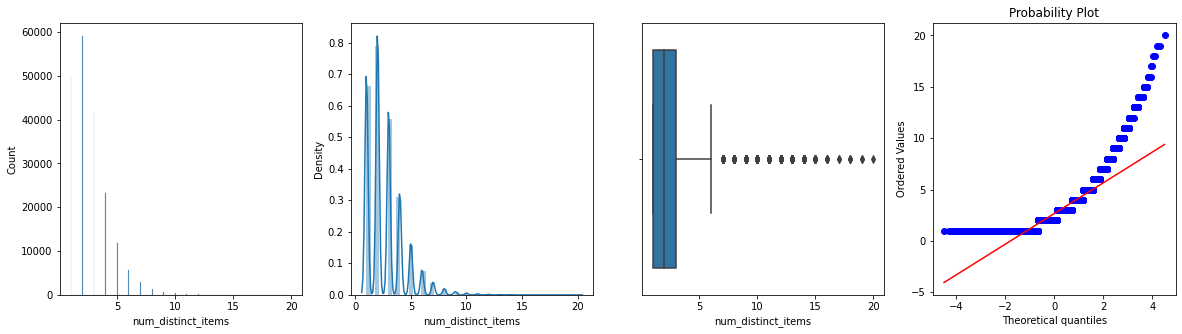

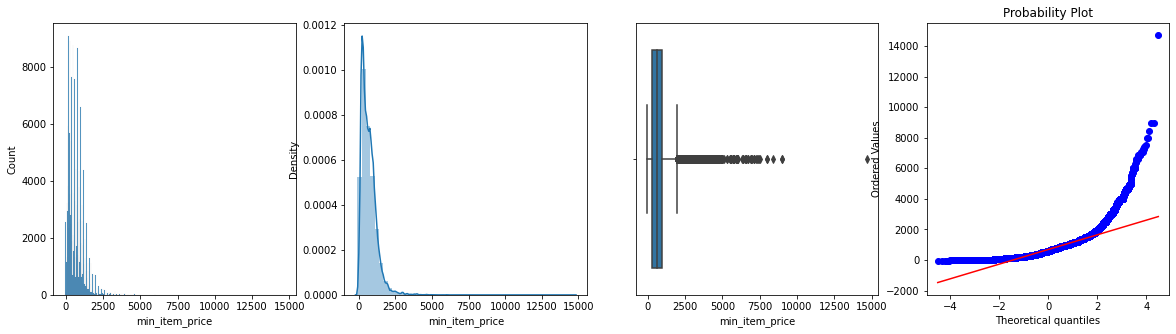

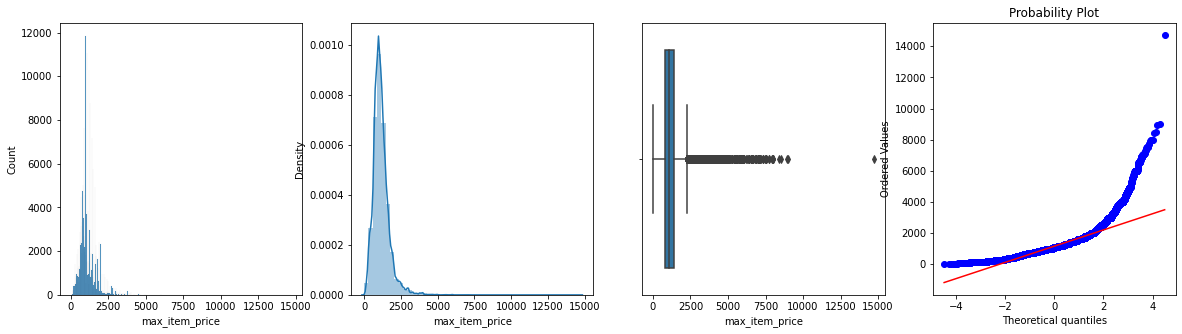

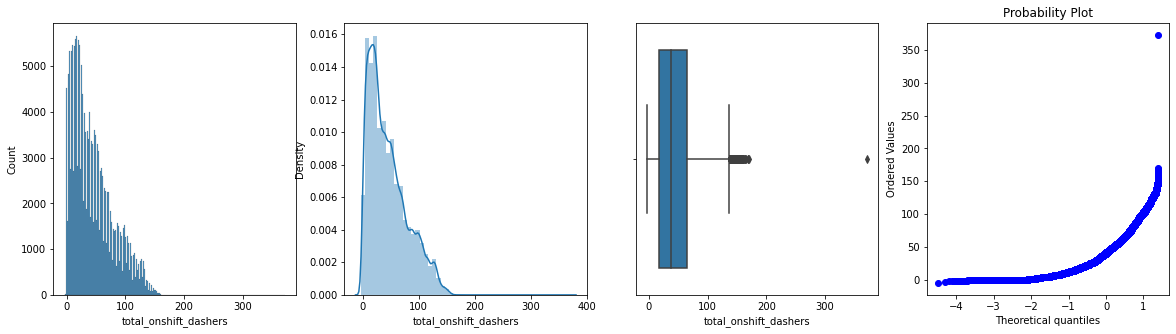

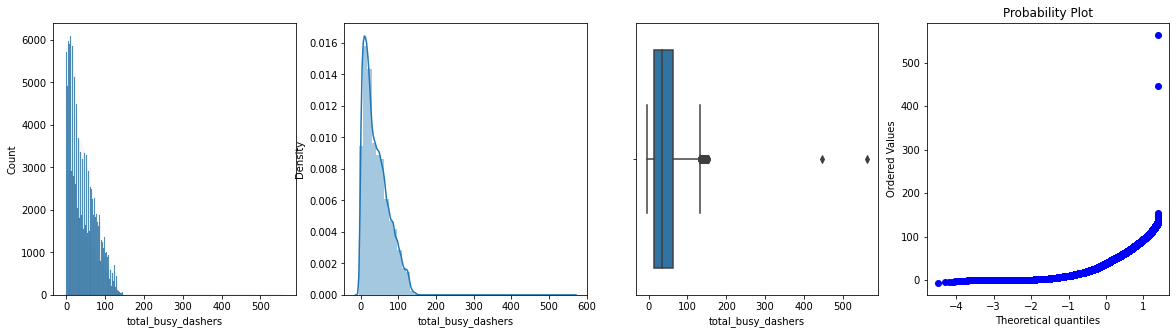

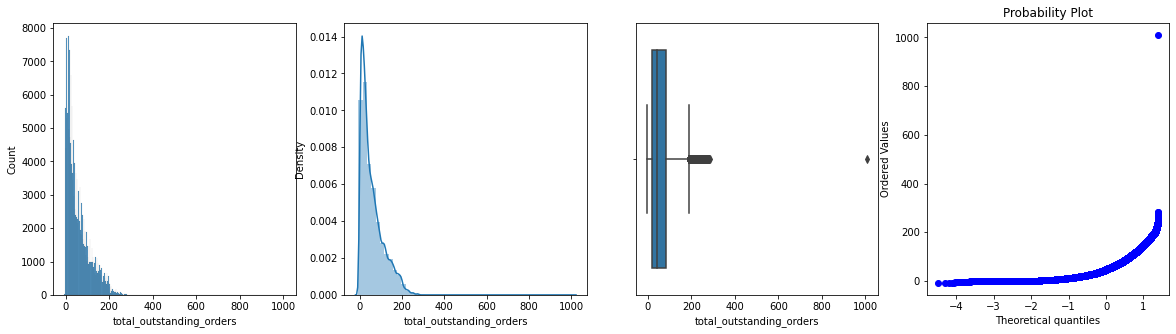

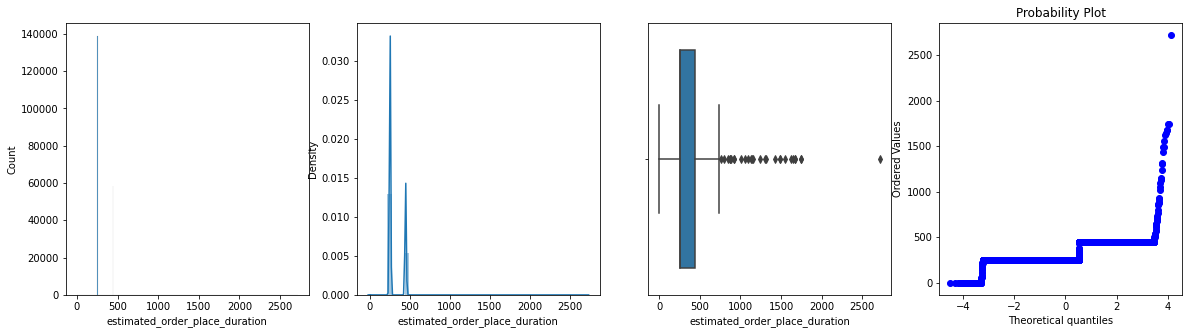

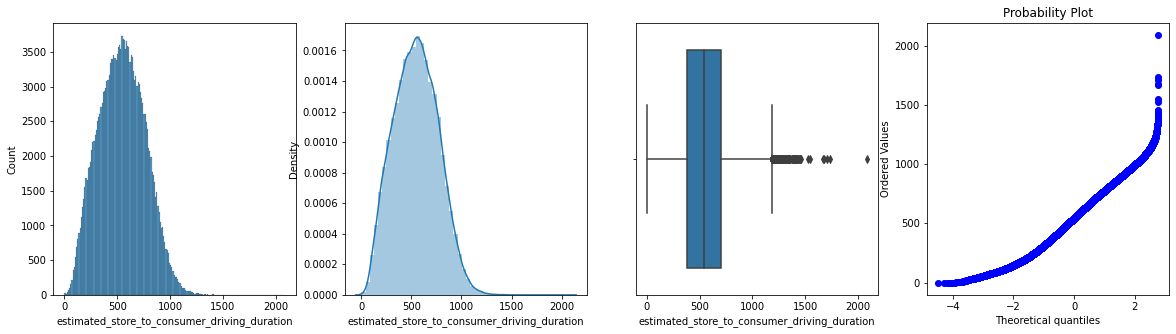

In [183]:
for feature in numericFeature:
  fig, ax = plt.subplots(1,4,figsize=(20, 5))
  sns.histplot(df[feature], ax=ax[0])
  sns.distplot(df[feature], ax=ax[1])
  sns.boxplot(df[feature],ax=ax[2])
  sp.probplot(df[feature], plot=ax[3], fit=True)
  fig.show()

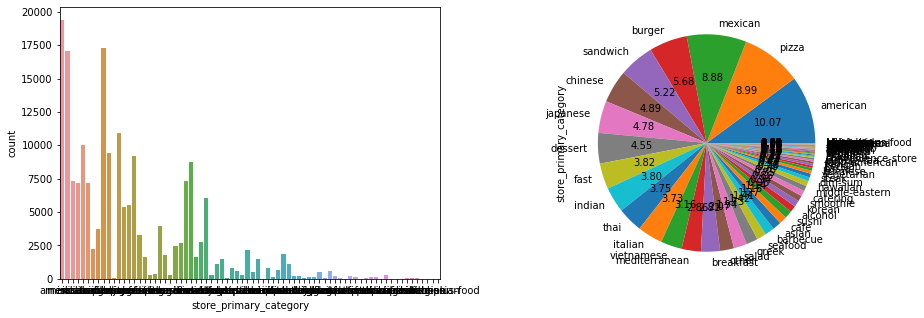

In [185]:
for feature in categoricalFeature:
  fig, ax = plt.subplots(1,2,figsize=(15, 5))
  sns.countplot(df[feature], ax=ax[0])
  df[feature].value_counts().plot(kind='pie',autopct='%.2f')
  fig.show()

In [186]:
df = df.drop(['market_id','store_id'],axis=1)

# Feature Engineering

## Null Value Handling

In [187]:
y = df['estimated_store_to_consumer_driving_duration']
X = df.drop('estimated_store_to_consumer_driving_duration',axis=1)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [189]:
featureNullLessThan5percent = []
featureNullMoreThan5percent = []

for key,value in (df.isnull().sum()/df.shape[0]*100).to_dict().items():
  if value < 0.05 and value > 0:
    featureNullLessThan5percent.append((key,value))
  elif value > 0.05:
    featureNullMoreThan5percent.append((key,value))


In [190]:
featureNullLessThan5percent,featureNullMoreThan5percent

([('estimated_order_place_duration', 0.001521645405898912)],
 [('store_primary_category', 2.4107935380791763),
  ('order_protocol', 0.5046790596231391),
  ('total_onshift_dashers', 8.137252415612082),
  ('total_busy_dashers', 8.137252415612082),
  ('total_outstanding_orders', 8.137759630747382),
  ('estimated_store_to_consumer_driving_duration', 0.26831680657350815)])

In [191]:
def checkNullImputation(data,feature):
  median = data[feature].median()
  data[f'{feature}_median'] = data[feature].fillna(median) 

  print("Original variable variance: ", data[feature].var())
  print("Variance after median imputation: ", data[f"{feature}_median"].var())

  fig = plt.figure()
  ax = fig.add_subplot(111)

  # original variable distribution
  data[feature].plot(kind="kde", ax=ax)

  # variable imputed with the median
  data[f"{feature}_median"].plot(kind="kde", ax=ax, color="red")
  # add legends
  lines, labels = ax.get_legend_handles_labels()
  ax.legend(lines, labels, loc="best")

  fig.show()



Original variable variance:  8116.269980568502
Variance after median imputation:  8116.1614813759825


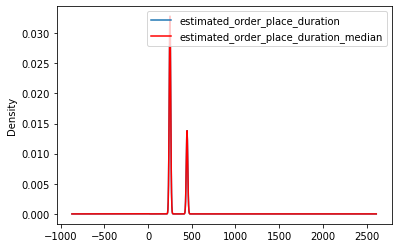

In [192]:
checkNullImputation(X_train.copy(),'estimated_order_place_duration')

In [193]:
X_train['estimated_order_place_duration'] = X_train['estimated_order_place_duration'].fillna(X_train['estimated_order_place_duration'].median())
X_test['estimated_order_place_duration'] = X_test['estimated_order_place_duration'].fillna(X_test['estimated_order_place_duration'].median())

Original variable variance:  2.263041652403404
Variance after median imputation:  2.2519773698754166


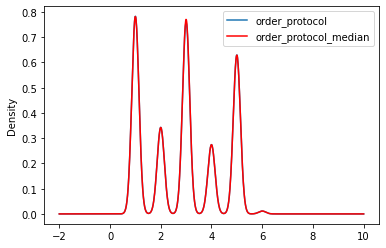

In [194]:
checkNullImputation(X_train.copy(),'order_protocol')

In [195]:
X_train['order_protocol'] = X_train['order_protocol'].fillna(X_train['order_protocol'].median())
X_test['order_protocol'] = X_test['order_protocol'].fillna(X_test['order_protocol'].median())

Original variable variance:  1190.8595600854849
Variance after median imputation:  1098.0680206109214


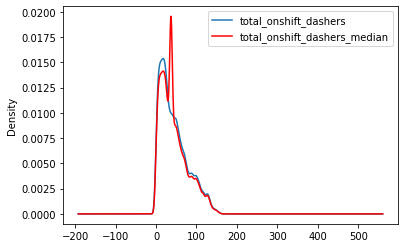

In [196]:
checkNullImputation(X_train.copy(),'total_onshift_dashers')

Original variable variance:  1033.3665340860805
Variance after median imputation:  953.3644014702868


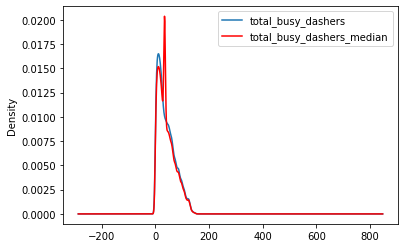

In [197]:
checkNullImputation(X_train.copy(),'total_busy_dashers')

Original variable variance:  2774.7119117715692
Variance after median imputation:  2569.671517616409


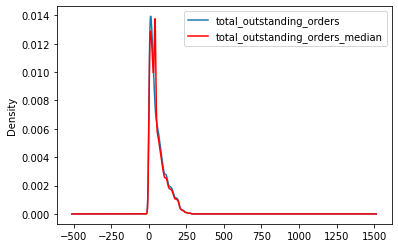

In [198]:
checkNullImputation(X_train.copy(),'total_outstanding_orders')

In [199]:
X_train['total_onshift_dashers_missing_indicator'] = np.where(X_train["total_onshift_dashers"].isnull(), 1, 0)
X_test['total_onshift_dashers_missing_indicator'] = np.where(X_test["total_onshift_dashers"].isnull(), 1, 0)

In [200]:
X_train['total_onshift_dashers'] = X_train["total_onshift_dashers"].fillna(X_train['total_onshift_dashers'].median())
X_test['total_onshift_dashers'] = X_test["total_onshift_dashers"].fillna(X_test['total_onshift_dashers'].median())

In [201]:
X_train['total_busy_dashers_missing_indicator'] = np.where(X_train["total_busy_dashers"].isnull(), 1, 0)
X_test['total_busy_dashers_missing_indicator'] = np.where(X_test["total_busy_dashers"].isnull(), 1, 0)

In [202]:
X_train['total_busy_dashers'] = X_train["total_busy_dashers"].fillna(X_train['total_busy_dashers'].median())
X_test['total_busy_dashers'] = X_test["total_busy_dashers"].fillna(X_test['total_busy_dashers'].median())

In [203]:
X_train['total_outstanding_orders_missing_indicator'] = np.where(X_train["total_outstanding_orders"].isnull(), 1, 0)
X_test['total_outstanding_orders_missing_indicator'] = np.where(X_test["total_outstanding_orders"].isnull(), 1, 0)

In [204]:
X_train['total_outstanding_orders'] = X_train["total_outstanding_orders"].fillna(X_train['total_outstanding_orders'].median())
X_test['total_outstanding_orders'] = X_test["total_outstanding_orders"].fillna(X_test['total_outstanding_orders'].median())

In [205]:
X_train['store_primary_category_missing_indicator'] = np.where(X_train["store_primary_category"].isnull(), 1, 0)
X_test['store_primary_category_missing_indicator'] = np.where(X_test["store_primary_category"].isnull(), 1, 0)

In [207]:
X_train['store_primary_category'] = X_train["store_primary_category"].fillna(X_train['store_primary_category'].mode()[0])
X_test['store_primary_category'] = X_test["store_primary_category"].fillna(X_test['store_primary_category'].mode()[0])

In [208]:
X_train.isnull().sum()

store_primary_category                        0
order_protocol                                0
total_items                                   0
subtotal                                      0
num_distinct_items                            0
min_item_price                                0
max_item_price                                0
total_onshift_dashers                         0
total_busy_dashers                            0
total_outstanding_orders                      0
estimated_order_place_duration                0
total_onshift_dashers_missing_indicator       0
total_busy_dashers_missing_indicator          0
total_outstanding_orders_missing_indicator    0
store_primary_category_missing_indicator      0
dtype: int64

In [209]:
X_test.isnull().sum()

store_primary_category                        0
order_protocol                                0
total_items                                   0
subtotal                                      0
num_distinct_items                            0
min_item_price                                0
max_item_price                                0
total_onshift_dashers                         0
total_busy_dashers                            0
total_outstanding_orders                      0
estimated_order_place_duration                0
total_onshift_dashers_missing_indicator       0
total_busy_dashers_missing_indicator          0
total_outstanding_orders_missing_indicator    0
store_primary_category_missing_indicator      0
dtype: int64

In [210]:
X_train.sample(5)

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,total_onshift_dashers_missing_indicator,total_busy_dashers_missing_indicator,total_outstanding_orders_missing_indicator,store_primary_category_missing_indicator
4486,thai,3.0,2,1790,2,895,895,61.0,53.0,81.0,251.0,0,0,0,0
36826,convenience-store,4.0,4,853,2,164,199,23.0,22.0,22.0,251.0,0,0,0,0
152029,indian,3.0,4,5200,2,800,1800,92.0,71.0,136.0,251.0,0,0,0,0
257579,breakfast,2.0,2,2250,2,950,1300,40.0,48.0,29.0,251.0,0,0,0,0
256165,mexican,1.0,2,3790,2,1895,1895,59.0,61.0,72.0,446.0,0,0,0,0


In [211]:
X_test.sample(5)

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,total_onshift_dashers_missing_indicator,total_busy_dashers_missing_indicator,total_outstanding_orders_missing_indicator,store_primary_category_missing_indicator
231517,american,5.0,2,550,1,275,275,23.0,33.0,11.0,251.0,0,0,0,1
144916,mexican,4.0,2,1800,2,900,900,51.0,45.0,71.0,446.0,0,0,0,0
222116,breakfast,1.0,2,2798,2,1399,1399,43.0,42.0,47.0,446.0,0,0,0,0
274521,breakfast,2.0,1,2200,1,2200,2200,37.0,35.0,41.0,251.0,1,1,1,0
204750,middle-eastern,2.0,1,1699,1,1099,1099,46.0,47.0,65.0,251.0,0,0,0,0


## Cardinality handling

In [248]:
top30duration = list(df.sort_values('estimated_store_to_consumer_driving_duration',ascending=False).dropna()['estimated_store_to_consumer_driving_duration'][:30])

In [269]:
df.groupby('store_primary_category').apply(lambda value:value.loc[value['estimated_store_to_consumer_driving_duration']>top30duration[-1]])
# .loc[value['estimated_store_to_consumer_driving_duration']>top30duration[-1]]

store_primary_category  order_protocol  \
store_primary_category                                                 
american               27843                american             3.0   
                       219308               american             1.0   
argentine              146823              argentine             2.0   
breakfast              39787               breakfast             3.0   
burger                 213927                 burger             3.0   
caribbean              38434               caribbean             4.0   
                       38436               caribbean             4.0   
                       38442               caribbean             4.0   
                       38453               caribbean             4.0   
chinese                150924                chinese             3.0   
                       192926                chinese             3.0   
fast                   230316                   fast             4.0   
greek                  210929                  greek             3.0   
                       210949                  greek             3.0   
italian                158871                italian             3.0   
                       240355                italian             5.0   
                       273905                italian             1.0   
japanese               24309                japanese             1.0   
mediterranean          7068            mediterranean             2.0   
                       212626          mediterranean             5.0   
middle-eastern         193650         middle-eastern             3.0   
pizza                  103062                  pizza             1.0   
salad                  218591                  salad             1.0   
sandwich               230302               sandwich             3.0   
seafood                102267                seafood             2.0   
                       244677                seafood             1.0   
thai                   3508                     thai             3.0   
                       7062                     thai             3.0   
                       7961                     thai             3.0   
                       7966                     thai             3.0   
                       7975                     thai             3.0   
                       7984                     thai             3.0   
                       112657                   thai             1.0   
                       224234                   thai             1.0   

                               total_items  subtotal  num_distinct_items  \
store_primary_category                                                     
american               27843             1       809                   1   
                       219308            1      1325                   1   
argentine              146823            3      1800                   3   
breakfast              39787             1      1145                   1   
burger                 213927            3      1604                   3   
caribbean              38434             1      1475                   1   
                       38436            11      7058                  11   
                       38442             2      1740                   2   
                       38453            10      7333                  10   
chinese                150924            5      3190                   4   
                       192926            2      1350                   2   
fast                   230316            3      1352                   3   
greek                  210929            4      1615                   3   
                       210949            2      1357                   2   
italian                158871            2      2670                   2   
                       240355            2      3050                   2   
                       273905            3      4900                 

In [213]:
for key,value in (df['store_primary_category'].value_counts()/df.shape[0]*100).to_dict().items():
  if value>=1:
    print(key,value)


american 9.829322106971672
pizza 8.771778549871929
mexican 8.662220080647206
burger 5.5453830742309345
sandwich 5.093961603814258
chinese 4.776444929116685
japanese 4.660799878268367
dessert 4.439146864142426
fast 3.7249879536405364
indian 3.7036849179579523
thai 3.659049986051584
italian 3.637746950368999
vietnamese 3.0869113134335926
mediterranean 2.7937409652304024
breakfast 2.747077172782836
other 2.0217595293043544
salad 1.8969846060206437
greek 1.6849686794653953
seafood 1.383175673962111
barbecue 1.379117952879714
asian 1.2416626512135123
cafe 1.126017600365195
sushi 1.1082650706297077
